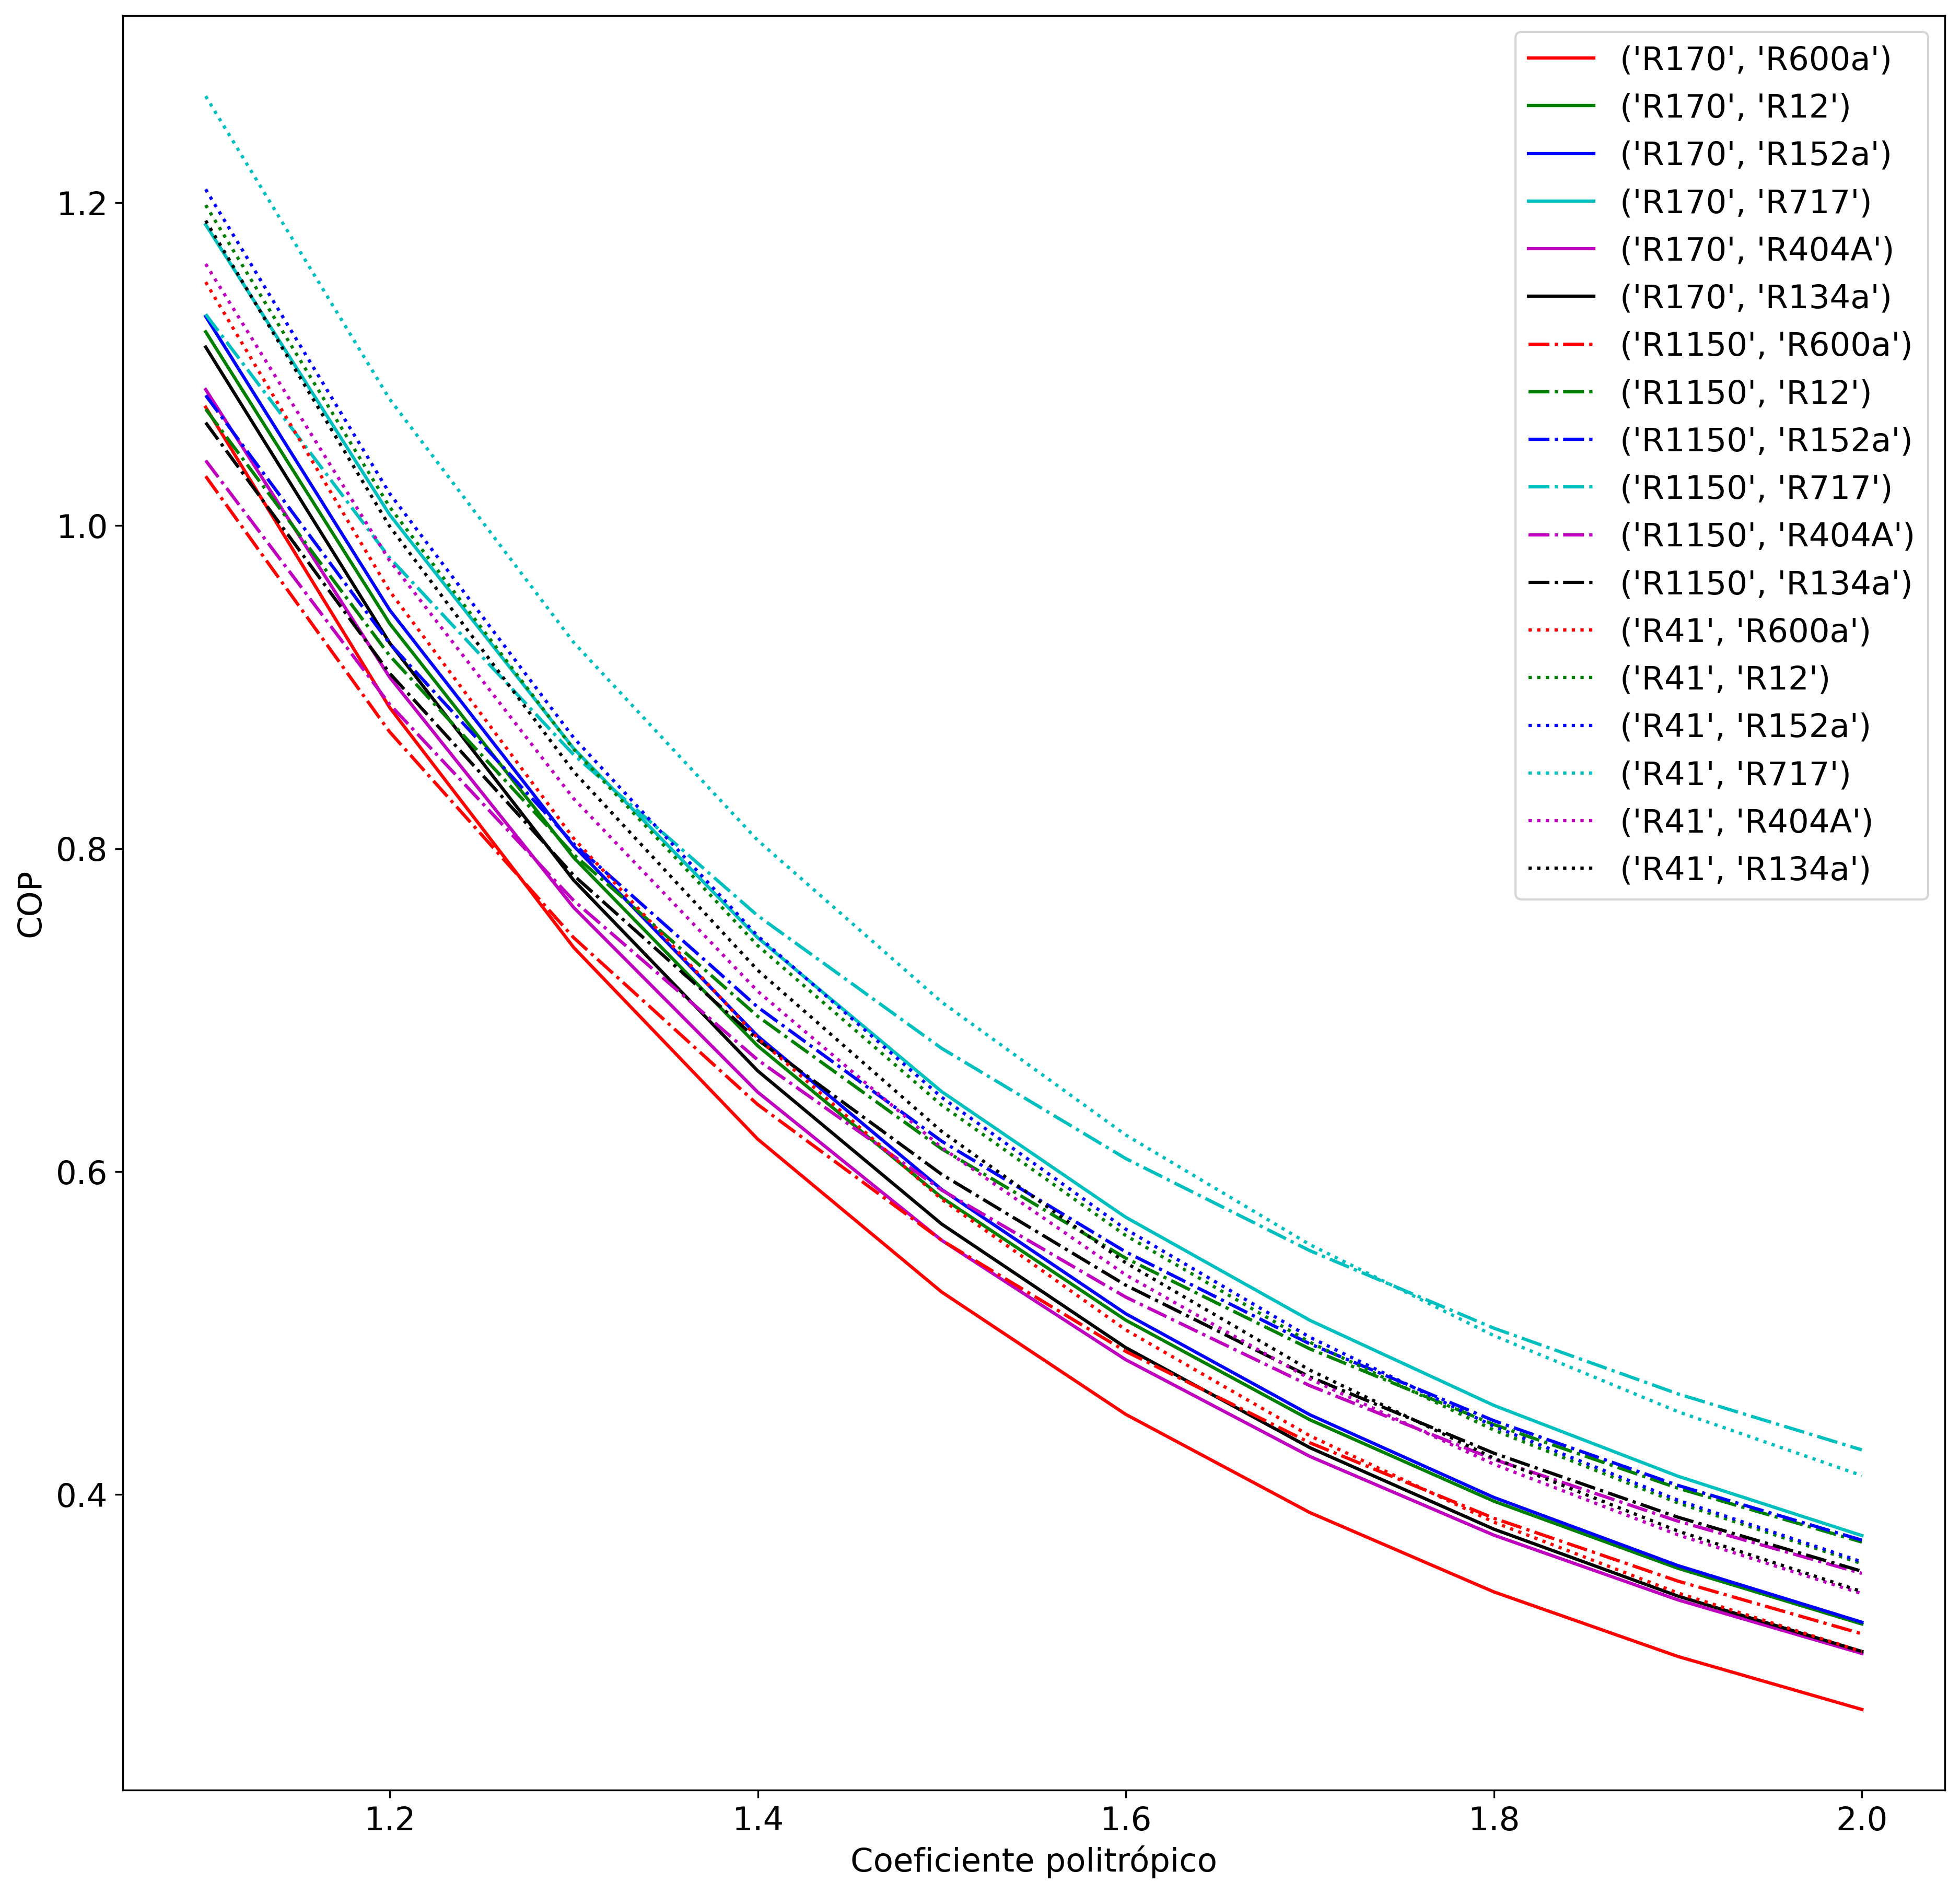

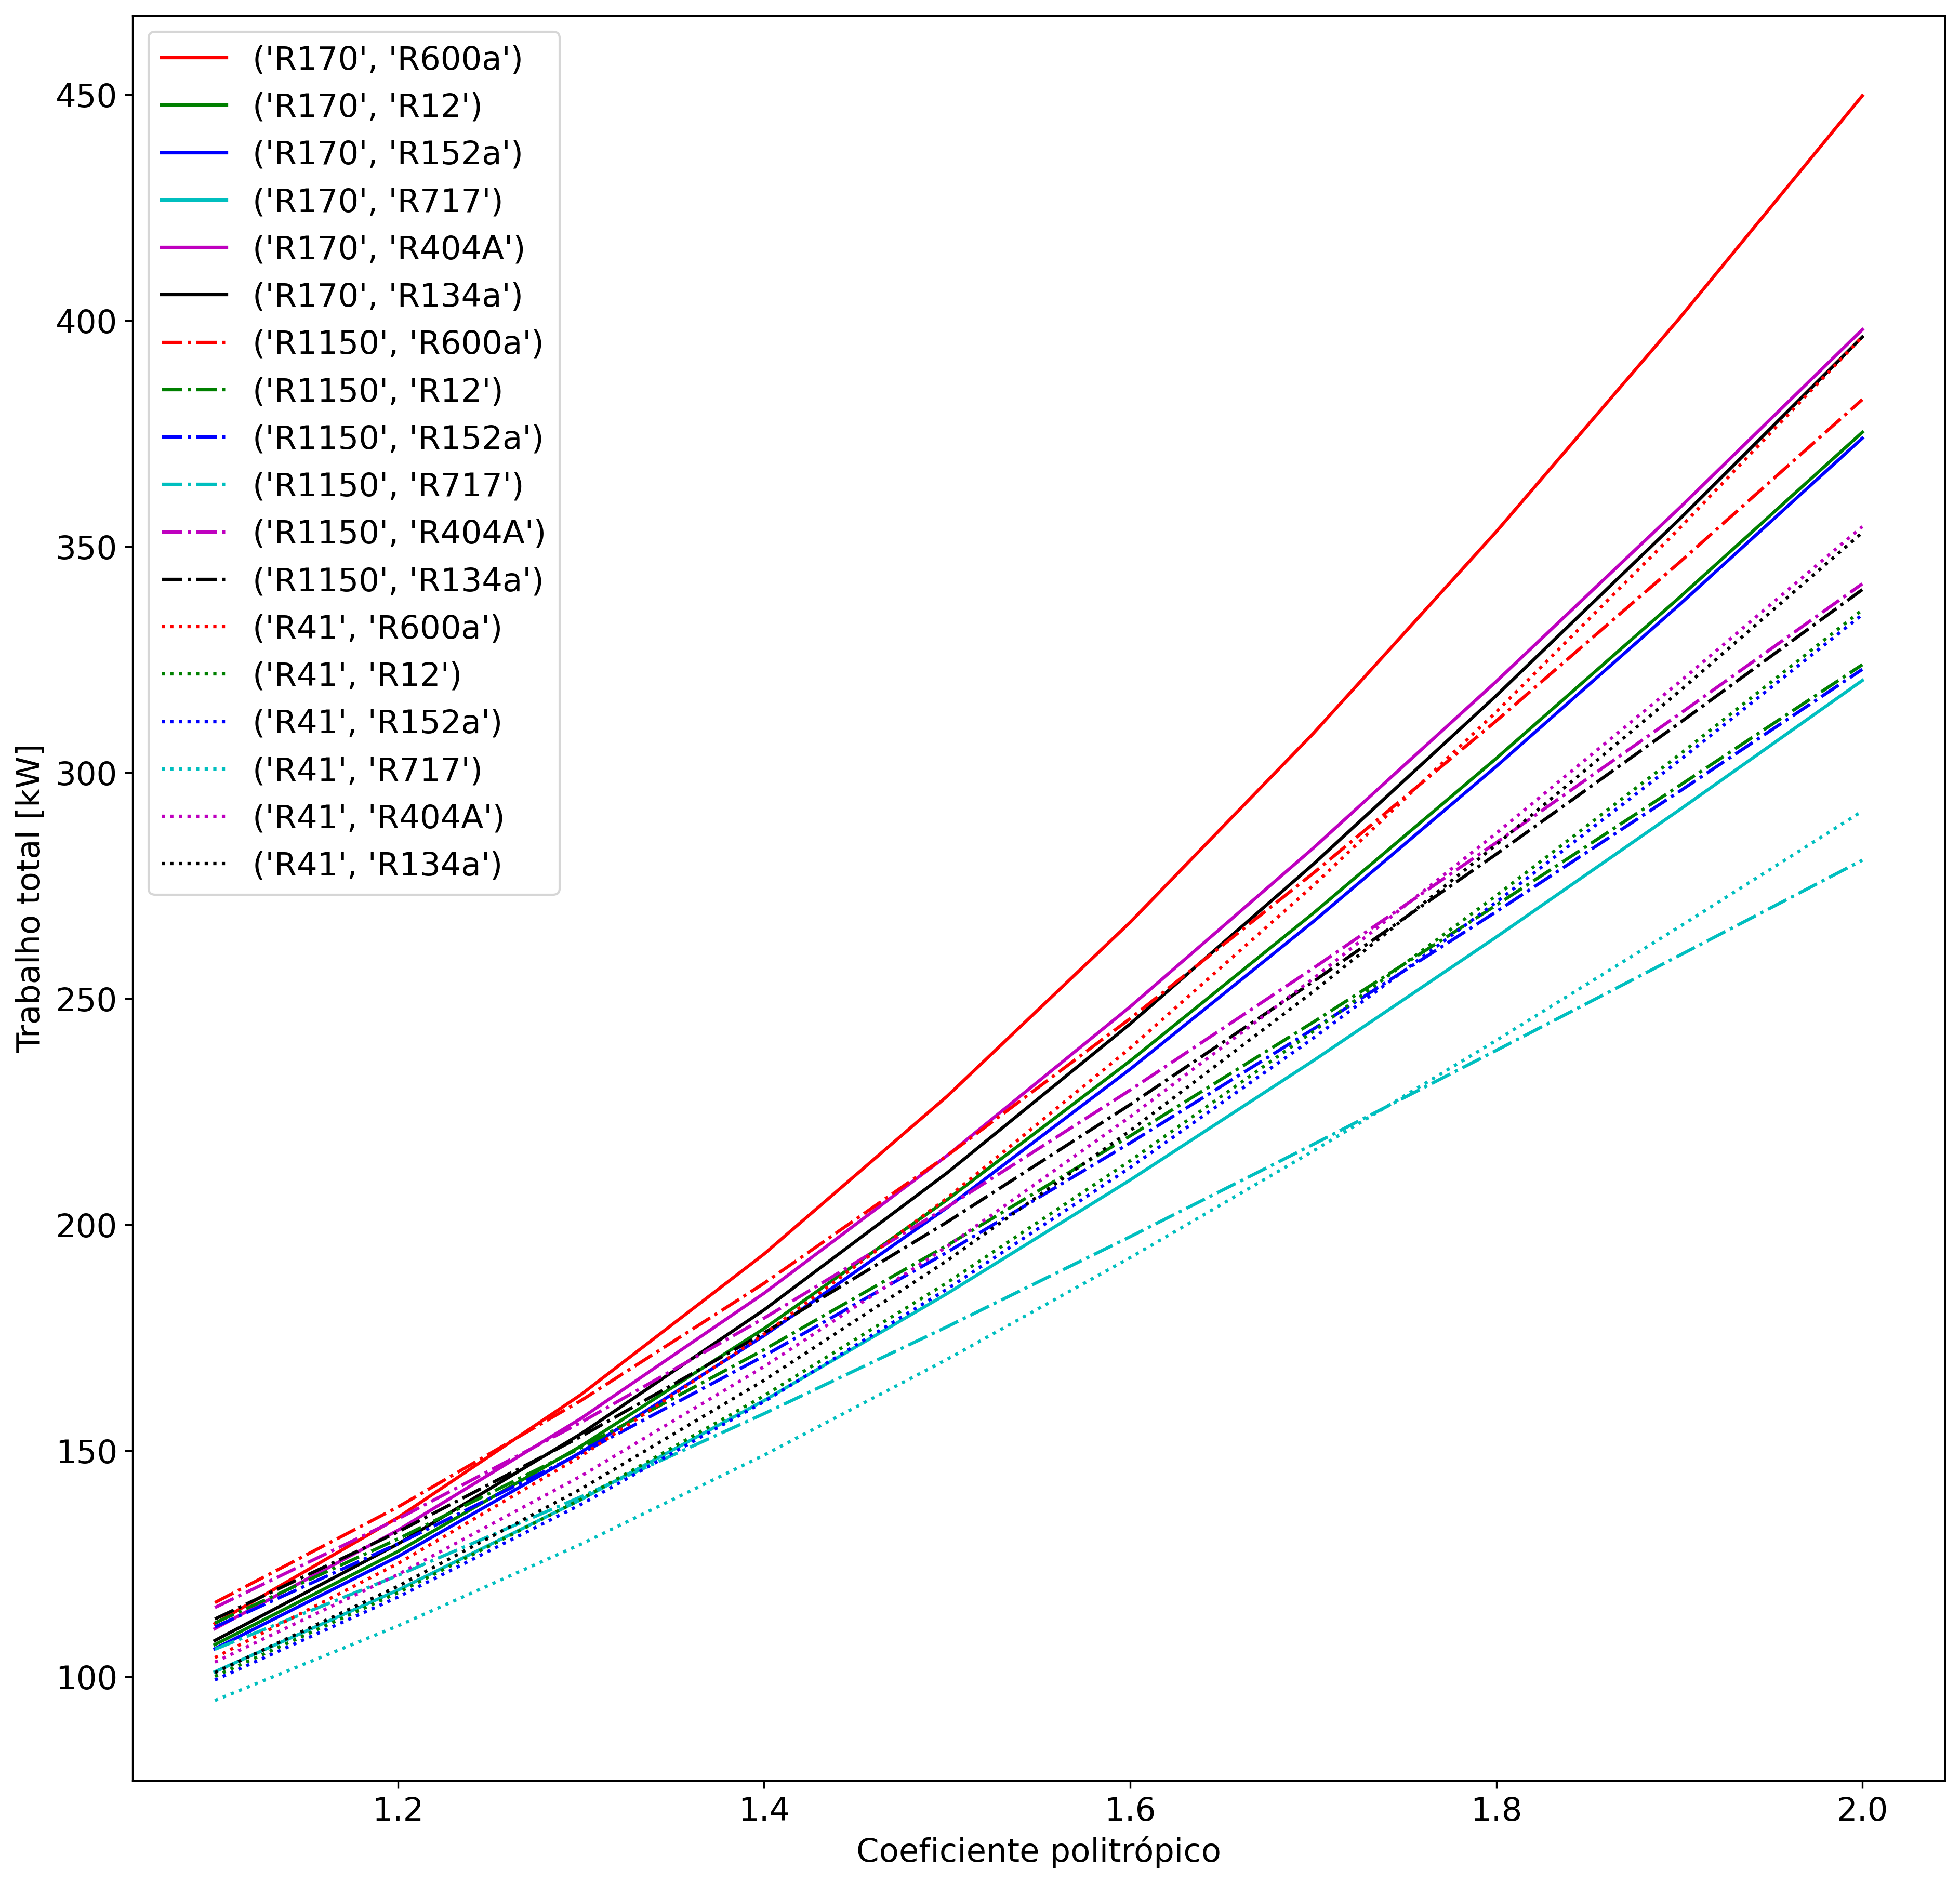

In [4]:
from CoolProp.CoolProp import PropsSI as CP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data

#Listas
registro_fluidos = []
COP_lista = []
lista_n = []
Wcomp_total_lista = []
cont = []

#Lista de coeficientes politrópicos
for n in range (110000, 210000, 10000):
    n = n / 100000
    cont.append(n)
    
#Lista de características para as curvas do gráfico
lista_cor = ['r','g','b', 'c', 'm', 'k']
lista_ls = ['-', '-.', ':']
caracteristicas = []
for ls in lista_ls:
    for cor in lista_cor:
        caracteristicas.append((cor, ls))

#Dados do problema
Pfrig = 120 * 1000 #[W]
T6 = -80 + 273.15 #[K]
T3 = -8 + 273.15 #[K]
T7 = -12 + 273.15 #[K]
T11 = 35 + 273.15 #[K]
fluid_high_lista = ['R600a', 'R12', 'R152a', 'R717', 'R404A', 'R134a']
fluid_low_lista = ['R170', 'R1150', 'R41']
drop_suc = 12000 #[Pa]
drop_desc = 24000 #[Pa]
efet = 0.7 #efetividade do trocador intermediário

for fluid_low in fluid_low_lista:
    for fluid_high in fluid_high_lista:
        #Pressão crítica do fluido superior
        P_crit_high = CP('PCRIT', fluid_high)
        #Ciclo inferior
        P6 = CP('P', 'T', T6, 'Q', 1, fluid_low)
        P3 = CP('P', 'T', T3, 'Q', 0, fluid_low)
        cp6 = CP('CP0MASS', 'T', T6, 'Q', 1, fluid_low)
        cp3 = CP('CP0MASS', 'T', T3, 'Q', 0, fluid_low)
        h6 = CP('H', 'T', T6, 'Q', 1, fluid_low)
        h3 = CP('H', 'T', T3, 'Q', 0, fluid_low)
        P1 = P6
        P4 = P3
        #Comparação entre os calores específicos nos pontos 3 e 6
        if cp6 < cp3:
            T1 = efet * (T3 - T6) + T6
            h1 = CP('H', 'T', T1, 'P', P1, fluid_low)
            ha = h1
            Pa = P1 - drop_suc
            Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
            Pb = Pa
            Tb = Ta + 4 #considerei um superaquecimento de 4°C na admissão
            vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
            P2 = P3
            Pc = P2 + drop_desc
            h4 = h3 + h6 - h1
            T4 = CP('T', 'H', h4, 'P', P4, fluid_low)
            h5 = h4
        else:
            T4 = T3 - efet * (T3 - T6)
            h4 = CP('H', 'T', T4, 'P', P4, fluid_low)
            h1 = h3 + h6 - h4
            T1 = CP('T', 'H', h1, 'P', P1, fluid_low)
            ha = h1
            Pa = P1 - drop_suc
            Ta = CP('T', 'H', ha, 'P', Pa, fluid_low)
            Pb = Pa
            Tb = Ta + 4 #considerei um superaquecimento de 4°C na admissão
            vb = 1 / CP('D', 'T', Tb, 'P', Pb, fluid_low)
            P2 = P3
            Pc = P2 + drop_desc
            h5 = h4
        m_flow_low = Pfrig / (h6 - h5)
        #Ciclo superior
        P7 = CP('P', 'T', T7, 'Q', 1, fluid_high)
        P11 = CP('P', 'T', T11, 'Q', 0, fluid_high)
        h11 = CP('H', 'T', T11, 'Q', 0, fluid_high)
        h12 = h11
        P10 = P11
        #Pressão intermediária
        P_int = (P7 * P11) ** 0.5
        P8 = P_int
        P9 = P_int
        P12 = P_int
        P13 = P_int
        h13 = CP('H', 'P', P13, 'Q', 0, fluid_high)
        h14 = h13
        h9 = CP('H', 'P', P9, 'Q', 1, fluid_high)
        h7 = CP('H', 'T', T7, 'Q', 1, fluid_high)
        #CBP
        hw = h7
        Pw = P7 - drop_suc
        Tw = CP('T', 'H', hw, 'P', Pw, fluid_high)
        Px = Pw
        Tx = Tw + 4 #superaquecimento de 4°C na admissão
        vx = 1 / CP('D', 'T', Tx, 'P', Px, fluid_high)
        Py = P8 + drop_desc
        #CAP
        he = h9
        Pe = P9 - drop_suc
        Te = CP('T', 'H', he, 'P', Pe, fluid_high)
        Pf = Pe
        Tf = Te + 4 #considerei um superaquecimento de 4°C na admissão
        vf = 1 / CP('D', 'T', Tf, 'P', Pf, fluid_high)
        Pg = P10 + drop_desc
        par_fluido = (fluid_low, fluid_high)
        registro_fluidos.append(par_fluido)
        #Registro dos graus de subresfriamento e superaquecimento
        grau_subresf = T3 - T4
        grau_superaq = T1 - T6
        #print('O grau de subresfriamento ({}, {}) é igual a {:0.2f}°C.'.format(fluid_low,fluid_high,grau_subresf))
        #print('O grau de superaquecimento ({}, {}) é igual a {:0.2f}°C.'.format(fluid_low,fluid_high,grau_superaq))
        #Loop nos dois ciclos
        for n in cont:
            #Ciclo inferior
            vc = (Pb * vb ** n / Pc)**(1 / n)
            hc = CP('H', 'P', Pc, 'D', 1 / vc, fluid_low)
            h2 = hc
            #Trabalho específico do compressor low
            w_low = n / (n-1) * Pb * vb * ((Pc/Pb)**((n-1)/n) - 1)
            #Trabalho do compressor low
            Wcomp_low = m_flow_low * w_low
            #Calor trocado no trocador central
            Qcond_low =  m_flow_low * (h2 - h3)
            #Ciclo superior
            Qevap_high = Qcond_low
            #CBP
            m_CBP = Qevap_high / (h7 - h14)
            vy = (Px * vx ** n / Py)**(1 / n)
            hy = CP('H', 'P', Py, 'D', 1 / vy, fluid_high)
            h8 = hy
            #Trabalho específico do CBP
            w_CBP = n / (n-1) * Px * vx * ((Py/Px)**((n-1)/n) - 1)
            #Trabalho do CBP
            W_CBP = m_CBP * w_CBP
            #CAP
            m_CAP = m_CBP * (h13 - h8) / (h12 - h9)
            vg = (Pf * vf ** n / Pg)**(1 / n)
            #Verificação da pressão crítica:
            if P_crit_high > P10:
                lista_n.append(n)
                #Trabalho específico do CAP
                w_CAP = n / (n-1) * Pf * vf * ((Pg/Pf)**((n-1)/n) - 1)
                #Trabalho do CAP
                W_CAP = m_CAP * w_CAP
                #Trabalho total do ciclo superior
                Wcomp_high = W_CAP + W_CBP
                #Trabalho total do ciclo
                Wcomp_total = Wcomp_low + Wcomp_high
                Wcomp_total_lista.append(Wcomp_total / 1000)
                #COP
                COP = Pfrig / Wcomp_total
                COP_lista.append(COP)
            else:
                 print ('A pressão P10 = {:0.2f} kPa (n = {}, fluido inf = {}, fluido sup = {}) é maior do que a ' 
               'pressão crítica do {} e, por isso, o ponto não foi incluído no gráfico'.format(P10 / 1000,n,fluid_low,
                                                                                               fluid_high, fluid_high))

                    
if len(lista_n) != 0:
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.figure(figsize = [15, 15], dpi = 300)
    for i in range (0, len(COP_lista), len(cont)):
        eixo_x = []
        eixo_y = []
        for j in range (i, i + len(cont), 1):
            eixo_x.append(lista_n[j])
            eixo_y.append(COP_lista[j])
        plt.plot(eixo_x, eixo_y, color = caracteristicas[int(i/len(cont))][0], 
                 linestyle = caracteristicas [int(i/len(cont))][1], 
                 label=registro_fluidos[int(i/len(cont))])
        plt.xlabel('Coeficiente politrópico', size = 15)
        plt.ylabel('COP', size = 15)
    plt.legend(prop={'size' : 15})
    plt.show()
else:
    print('Todos os pontos são inválidos')
    
if len(lista_n) != 0:
    plt.rc('xtick', labelsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.figure(figsize = [15, 15], dpi = 300)
    for i in range (0, len(Wcomp_total_lista), len(cont)):
        eixo_x = []
        eixo_y = []
        for j in range (i, i + len(cont), 1):
            eixo_x.append(lista_n[j])
            eixo_y.append(Wcomp_total_lista[j])
        plt.plot(eixo_x, eixo_y, color = caracteristicas[int(i/len(cont))][0], 
                 linestyle = caracteristicas [int(i/len(cont))][1], 
                 label=registro_fluidos[int(i/len(cont))])
        plt.xlabel('Coeficiente politrópico', size = 15)
        plt.ylabel('Trabalho total [kW]', size = 15)
    plt.legend(prop={'size' : 15})
    plt.show()
else:
    print('Todos os pontos são inválidos')